### Import semua Library yang dibutuhkan

In [19]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.7 MB/s eta 0:00:00


In [32]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Train Dataset

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Text Mining Project/train.csv')

In [5]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


### Analisa sederhana terhadap data

In [8]:
x = train.iloc[:,3:].sum()
rowsums = train.iloc[:,2:].sum(axis=1)
no_label_count = 0
for sum in rowsums.items():
    if sum==0:
        no_label_count +=1

print("Total number of articles = ",len(train))
print("Total number of articles without label = ",no_label_count)
print("Total labels = ",x.sum())

Total number of articles =  20972
Total number of articles without label =  0
Total labels =  26267


<ipython-input-8-c76054262e96>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rowsums = train.iloc[:,2:].sum(axis=1)


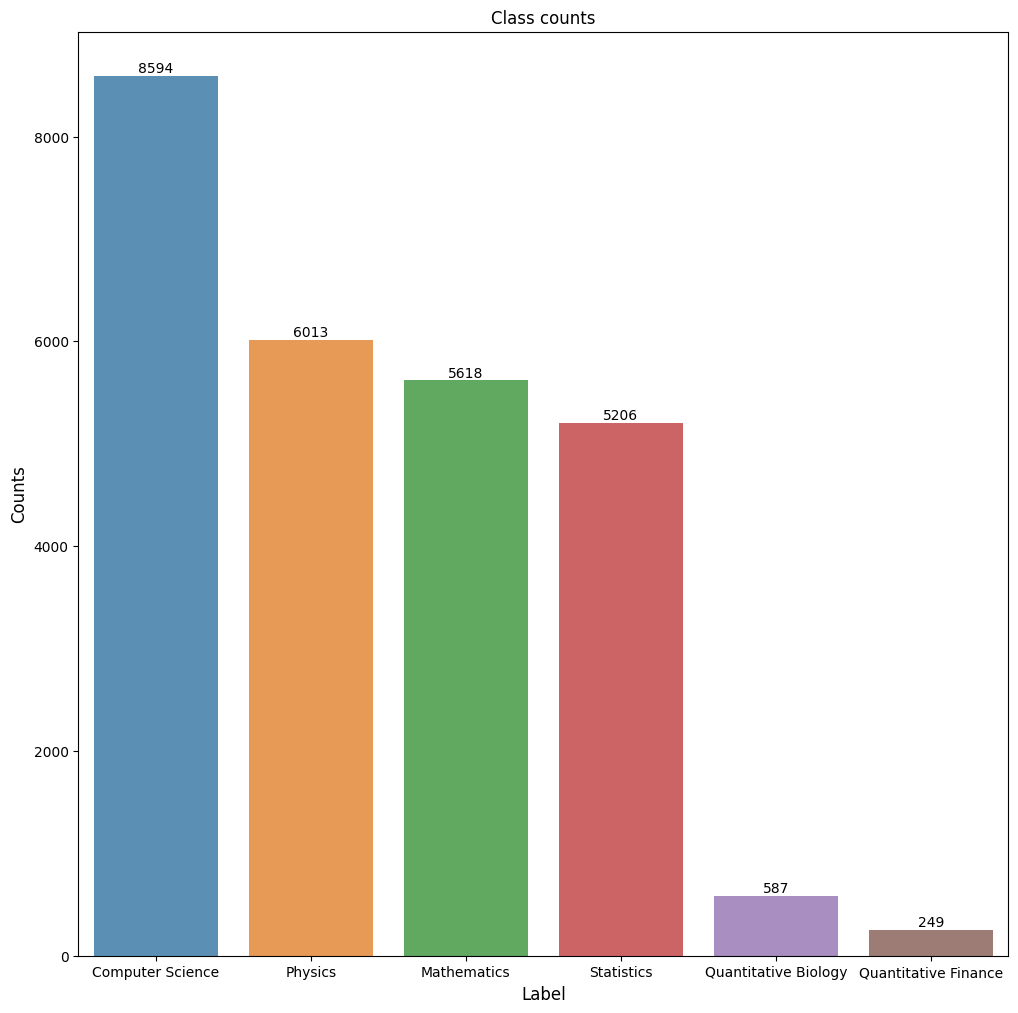

In [11]:
x = train.iloc[:,3:].sum()
plt.figure(figsize=(12,12))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Class counts")
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Label', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Data Preprocessing

In [12]:
train['Text']=train['TITLE']+' '+train['ABSTRACT']
train.drop(columns=['TITLE','ABSTRACT'], inplace=True)
train.head(5)

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [15]:
stopword_list = nltk.corpus.stopwords.words('english')

# Remove stopwords
def remove_stopwords(text):
    text = [w for w in text.split() if not w in stopword_list]
    return ' '.join(text)

# Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]"," ", text)
    text = ' '.join(text.split())
    return text

# Lemmatization
lemma = WordNetLemmatizer()
def lemmatize(sentence):
    lemmaSentence = ""
    for word in sentence.split():
        lemmaWord = lemma.lemmatize(word)
        lemmaSentence += lemmaWord
        lemmaSentence += " "
    lemmaSentence = lemmaSentence.strip()
    return lemmaSentence

train['Text'] = train['Text'].apply(lambda x: remove_stopwords(x))
train['Text'] = train['Text'].apply(lambda x:clean_text(x))
train['Text'] = train['Text'].apply(lemmatize)

In [17]:
X = train['Text'].values
y = train.iloc[:, 1:7].values

In [21]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Vectorization using BERT Tokenizer

In [23]:
# Menggunakan tokenizer dari model BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Membuat Dataset khusus untuk BERT
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Melakukan tokenisasi teks menggunakan tokenizer BERT
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

    def __len__(self):
        return len(self.texts)

# Menginisialisasi DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Modelling and Experimentation

In [24]:
# Menginisialisasi model BERT untuk sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y_train.shape[1])

# Mengoptimasi model menggunakan AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Melatih model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

### Model Training

In [25]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels.argmax(dim=1)).item()

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_accuracy = correct_predictions / len(train_dataset)

    print(f'Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}')

Epoch 1: Train Loss = 0.2263, Train Accuracy = 0.7509
Epoch 2: Train Loss = 0.1589, Train Accuracy = 0.7858
Epoch 3: Train Loss = 0.1303, Train Accuracy = 0.8024
Epoch 4: Train Loss = 0.1043, Train Accuracy = 0.8253
Epoch 5: Train Loss = 0.0803, Train Accuracy = 0.8362


### Model Evaluation

In [26]:
# Menguji model
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.sigmoid(logits).cpu().numpy())

### Confusion Matrix

In [34]:
# Menghitung confusion matrix
confusion_mat = confusion_matrix(y_test.argmax(axis=1), np.array(y_pred_bin).argmax(axis=1))

print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[1432   57   64  135    3    1]
 [  27 1060   25    7   11    0]
 [  88   56  710   41    2    1]
 [ 174   17   30  121    1    0]
 [  17   21    0   15   39    0]
 [   5    2    4    6    1   22]]


### Classification Report

In [28]:
# Mengkonversi prediksi menjadi label biner
threshold = 0.5
y_pred_bin = [[1 if pred >= threshold else 0 for pred in label] for label in predictions]

# Melihat laporan klasifikasi
target_names = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
report = classification_report(y_test, y_pred_bin, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
                       precision    recall  f1-score   support

    Computer Science       0.82      0.85      0.83      1692
             Physics       0.86      0.92      0.89      1226
         Mathematics       0.86      0.78      0.82      1150
          Statistics       0.75      0.79      0.77      1069
Quantitative Biology       0.65      0.45      0.53       122
Quantitative Finance       0.84      0.60      0.70        45

           micro avg       0.82      0.83      0.82      5304
           macro avg       0.80      0.73      0.76      5304
        weighted avg       0.82      0.83      0.82      5304
         samples avg       0.86      0.86      0.84      5304



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
